In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
import re
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
import os
from wordcloud import WordCloud
from sentence_transformers import SentenceTransformer
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report
# !pip install hdbscan
import hdbscan
from scipy.cluster.hierarchy import fcluster  
from sklearn.cluster import AgglomerativeClustering

In [4]:
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv
/kaggle/input/imdb-dataset-cleaned/imdb-dataset-cleaned.csv


In [5]:
# Load original dataset
# df = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
df = pd.read_csv("./data/IMDB Dataset.csv")

## Data Exploration

In [33]:
df.head()

,review,sentiment,word_count,cleaned_review,clean_word_count
0,One of the other reviewers has mentioned that ...,1,307,reviewer mention watch oz episode ll hook righ...,150
1,A wonderful little production. <br /><br />The...,1,162,wonderful little production film technique una...,76
2,I thought this was a wonderful way to spend ti...,1,166,think wonderful way spend time hot summer week...,76
3,Basically there's a family where a little boy ...,0,138,basically s family little boy jake think s zom...,60
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,230,petter matteis love time money visually stunni...,112


In [4]:
# Get data types of fetures
df.dtypes

review       object
sentiment    object
dtype: object

In [5]:
# Shape of data frame
rows, cols = df.shape
print(f"Rows = {rows}\nFeatures = {cols}")

Rows = 50000
Features = 2


In [6]:
# Get count of unique values in sentiment column
df["sentiment"].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [7]:
# Count words in each review
df['word_count'] = df['review'].apply(lambda x: len(x.split()))
df[["review","word_count"]].sort_values(by = "word_count")

,review,word_count
28920,Primary plot!Primary direction!Poor interpreta...,4
27521,"Read the book, forget the movie!",6
13109,"More suspenseful, more subtle, much, much more...",8
40817,I hope this group of film-makers never re-unites.,8
31072,"What a script, what a story, what a mess!",9
...,...,...
12647,Titanic directed by James Cameron presents a f...,1839
31240,"(Some spoilers included:)<br /><br />Although,...",2108
31436,"Back in the mid/late 80s, an OAV anime by titl...",2125
40521,There's a sign on The Lost Highway that says:<...,2278


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


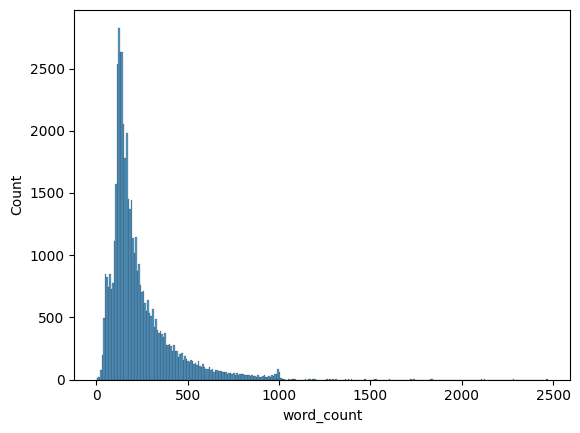

In [8]:
# Plot frequency of each word_count
sns.histplot(x = "word_count", data = df)
plt.show()

In [9]:
# Count missing values
df.isnull().sum()

review        0
sentiment     0
word_count    0
dtype: int64

In [10]:
# Count duplicates
df.duplicated().sum()

418

In [11]:
# Printing duplicates 
duplicates = df[df.duplicated()]
duplicates.sort_values(by = "word_count")

,review,sentiment,word_count
10868,"Love it, love it, love it! This is another abs...",positive,34
48010,Worst horror film ever but funniest film ever ...,positive,36
29043,I really enjoyed this movie. The script is fre...,positive,42
43831,The scenes are fast-paced. the characters are ...,positive,43
22234,I saw this in the summer of 1990. I'm still an...,negative,43
...,...,...,...
40420,"Dramatic license - some hate it, though it is ...",positive,743
25360,Why did I have to go out and buy (yes buy!) JA...,negative,776
47673,"After some internet surfing, I found the ""Home...",negative,866
20042,"Elfriede Jelinek, not quite a household name y...",negative,937


In [12]:
# Drop duplicates
df.drop_duplicates(inplace = True)
df.shape

(49582, 3)

## Text Preprocessing

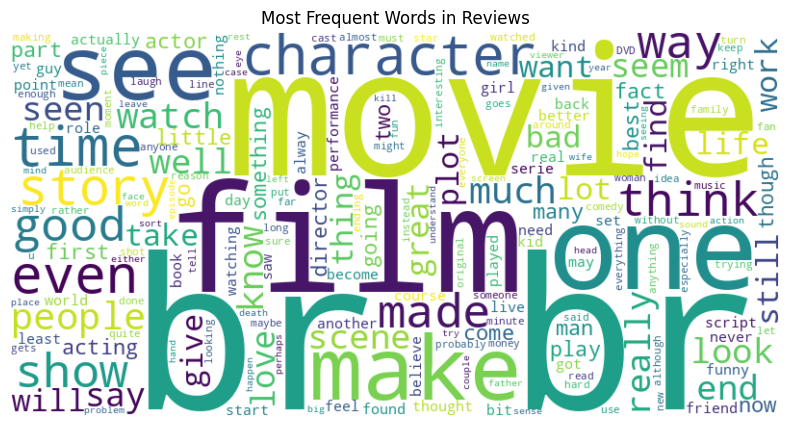

In [13]:
# Visualizing most frequent words
text = " ".join(review for review in df['review'])

wordcloud = WordCloud(width = 800, height = 400, background_color = "white").generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Reviews')
plt.show()

In [14]:
# Preprocess text function
# stop_words = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    if pd.isnull(text):
        return ""
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    # Lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # remove special symbols (except !|?)
    text = re.sub(r'[^\w\s\!?]', '', text)
    
    doc = nlp(text)
    
    # Lemmatize
    tokens = [
        token.lemma_ if token.lemma_ != '-PRON-' else token.text  # Keep pronouns as they are
        for token in doc
        if token.is_alpha and (token.text not in nlp.Defaults.stop_words or token.text in ["not", "no", "never"])
    ]
    
    # Join tokens back into a string
    return " ".join(tokens)


In [16]:
df.iloc[15, 0]

"Kind of drawn in by the erotic scenes, only to realize this was one of the most amateurish and unbelievable bits of film I've ever seen. Sort of like a high school film project. What was Rosanna Arquette thinking?? And what was with all those stock characters in that bizarre supposed Midwest town? Pretty hard to get involved with this one. No lessons to be learned from it, no brilliant insights, just stilted and quite ridiculous (but lots of skin, if that intrigues you) videotaped nonsense....What was with the bisexual relationship, out of nowhere, after all the heterosexual encounters. And what was with that absurd dance, with everybody playing their stereotyped roles? Give this one a pass, it's like a million other miles of bad, wasted film, money that could have been spent on starving children or Aids in Africa....."

In [15]:
clean = preprocess_text(df.iloc[15, 0])
print(clean)

kind draw erotic scene realize amateurish unbelievable bit film ve see sort like high school film project rosanna arquette thinking stock character bizarre suppose midwest town pretty hard involve no lesson learn no brilliant insight stilte ridiculous lot skin intrigue videotape nonsensewhat bisexual relationship heterosexual encounter absurd dance everybody play stereotype role pass like million mile bad wasted film money spend starve child aid africa


In [15]:
# preprocess reviews
# df["cleaned_review"] = df["review"].swifter.apply(preprocess_text)

import dask.dataframe as dd

# Converting DataFrame to Dask DataFrame
dask_df = dd.from_pandas(df, npartitions=4)

dask_df['cleaned_review'] = dask_df['review'].map_partitions(lambda df: df.apply(preprocess_text))

# bring back the result to Pandas
df = dask_df.compute()

In [16]:
print("Original Review:\n", df.iloc[0, 0])
print("\n")
print("Clean Review:\n", df.iloc[0, 3])

Original Review:
 One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show

In [17]:
# Count words in each clean review
df['clean_word_count'] = df['cleaned_review'].apply(lambda x: len(x.split()))
df[["review","word_count","cleaned_review","clean_word_count", "sentiment"]].sort_values(by = ["word_count", "clean_word_count"])

,review,word_count,cleaned_review,clean_word_count,sentiment
28920,Primary plot!Primary direction!Poor interpreta...,4,primary interpretation,2,negative
27521,"Read the book, forget the movie!",6,read book forget movie,4,negative
13109,"More suspenseful, more subtle, much, much more...",8,suspenseful subtle disturbing,3,negative
40817,I hope this group of film-makers never re-unites.,8,hope group filmmaker never reunite,5,negative
31072,"What a script, what a story, what a mess!",9,script story mess,3,negative
...,...,...,...,...,...
12647,Titanic directed by James Cameron presents a f...,1839,titanic direct james cameron present fictional...,831,positive
31240,"(Some spoilers included:)<br /><br />Although,...",2108,spoiler include commentator call film surreal ...,1005,positive
31436,"Back in the mid/late 80s, an OAV anime by titl...",2125,midlate s oav anime title bubblegum crisis thi...,1028,positive
40521,There's a sign on The Lost Highway that says:<...,2278,s sign lost highway say major spoiler ahead kn...,954,positive


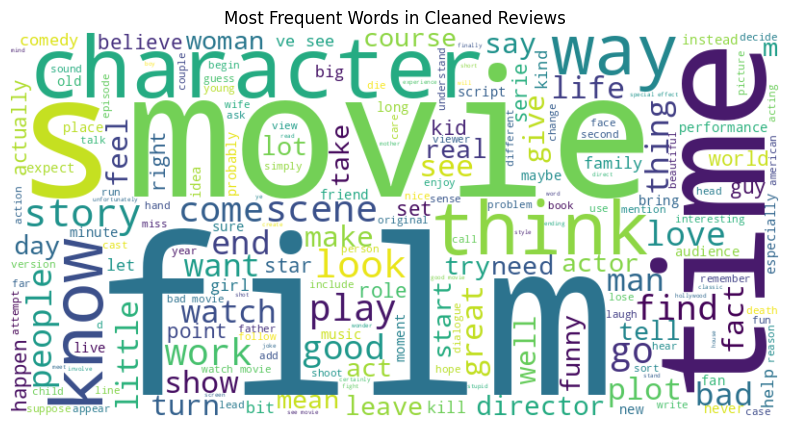

In [18]:
# Visualizing most frequent words in clean text
text = " ".join(review for review in df['cleaned_review'])

wordcloud = WordCloud(width = 800, height = 400, background_color = "white").generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Cleaned Reviews')
plt.show()

In [20]:
# save dataframe
df.to_csv("imdb-dataset-cleaned.csv", index = False)

## Load Saved Preprocessed Dataset

In [2]:
# Load saved sataset
# df = pd.read_csv("/kaggle/input/imdb-dataset-cleaned/imdb-dataset-cleaned.csv")
df = pd.read_csv("./data/imdb-dataset-cleaned.csv")
df.head()

,review,sentiment,word_count,cleaned_review,clean_word_count
0,One of the other reviewers has mentioned that ...,1,307,reviewer mention watch oz episode ll hook righ...,150
1,A wonderful little production. <br /><br />The...,1,162,wonderful little production film technique una...,76
2,I thought this was a wonderful way to spend ti...,1,166,think wonderful way spend time hot summer week...,76
3,Basically there's a family where a little boy ...,0,138,basically s family little boy jake think s zom...,60
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,230,petter matteis love time money visually stunni...,112


In [29]:
print("Before:", df["sentiment"].value_counts())
# df["sentiment"] = df["sentiment"].map({'negative': 0, 'positive': 1})
# print("After:", df["sentiment"].value_counts())

Before: sentiment
1    24884
0    24698
Name: count, dtype: int64
After: Series([], Name: count, dtype: int64)


In [6]:
samples = df['cleaned_review'].tolist()
labels = df["sentiment"].tolist()

## Word Embedding

In [7]:
# Load tokenizer and model
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)


model.eval()
model.cuda()  

# list to store embeddings
all_embeddings = []

batch_size = 64

for i in tqdm(range(0, len(samples), batch_size), desc="Embedding Batches"):
    batch_samples = samples[i:i+batch_size]

    encoded_input = tokenizer(
        batch_samples,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    encoded_input = {k: v.cuda() for k, v in encoded_input.items()}  # Move tensors to GPU

    
    with torch.no_grad():
        model_output = model(**encoded_input)

    # last hidden state
    last_hidden_state = model_output.last_hidden_state  # Shape: (batch_size, seq_len, hidden_dim)

    # Take average across the sequence length
    attention_mask = encoded_input['attention_mask']
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()

    sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    batch_embeddings = sum_embeddings / sum_mask  # (batch_size, hidden_dim)

    # Save batch embeddings
    all_embeddings.append(batch_embeddings)

# Stack all batches together
embeddings = torch.cat(all_embeddings, dim=0)

print(embeddings.shape)

Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Embedding Batches: 100%|██████████| 775/775 [12:03<00:00,  1.07it/s]


torch.Size([49582, 768])


In [8]:
embeddings_np = embeddings.cpu().numpy()
embeddings_np.shape

(49582, 768)

In [9]:
def visualize_clusters(x, y, labels, title = ""):
    plt.figure(figsize=(10,7))
    plt.scatter(x, y, c=labels, s = 3,alpha=0.5)
    plt.colorbar()
    plt.title(title)
    plt.show()

## Dimension Reduction

In [10]:
from sklearn.decomposition import PCA

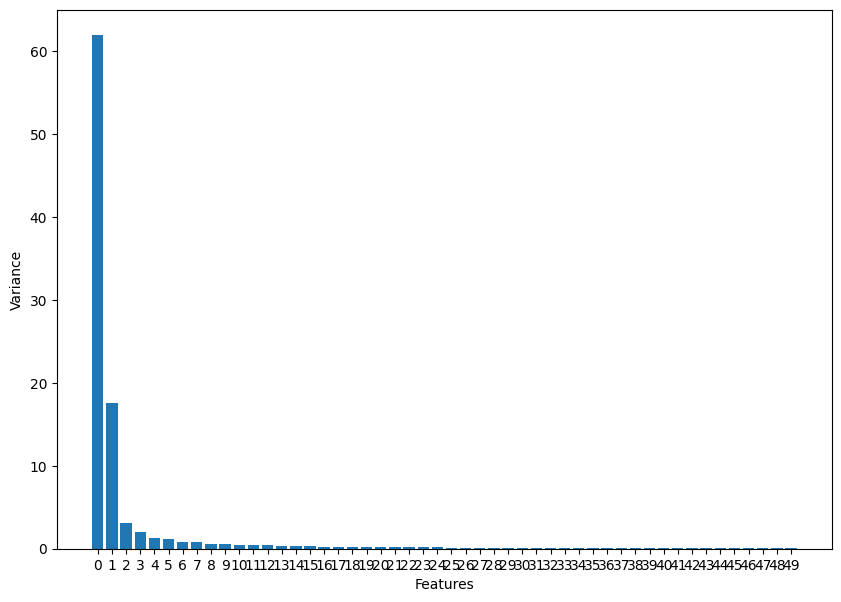

In [31]:
# instantiate the model object
pca_model = PCA()
pca_model.fit(embeddings_np)

features = range(pca_model.n_components_)

# visualize PCA features variance
plt.figure(figsize=(10,7))
plt.bar(features[:50], pca_model.explained_variance_[:50])
plt.xlabel("Features")
plt.ylabel("Variance")
plt.xticks(features[:50])
plt.show()

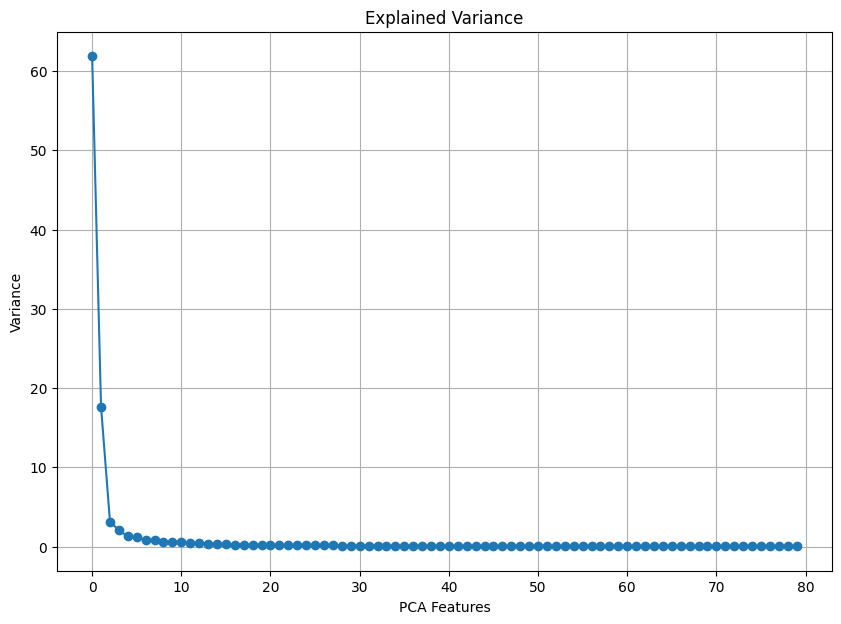

In [32]:
plt.figure(figsize=(10,7))
plt.plot(features[:80], pca_model.explained_variance_[:80], marker='o')
plt.xlabel("PCA Features")
plt.ylabel("Variance")
plt.title("Explained Variance")
plt.grid(True)
plt.show()

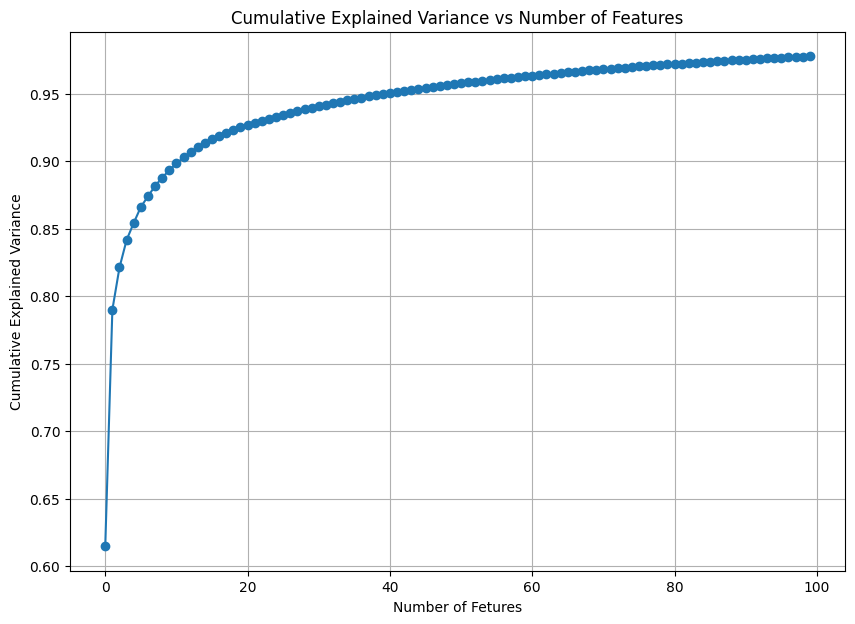

In [13]:
cumulative_variance = np.cumsum(pca_model.explained_variance_ratio_)

plt.figure(figsize=(10,7))
plt.plot(cumulative_variance[:100], marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.title('Cumulative Explained Variance vs Number of Features')
plt.show()

(49582, 2)


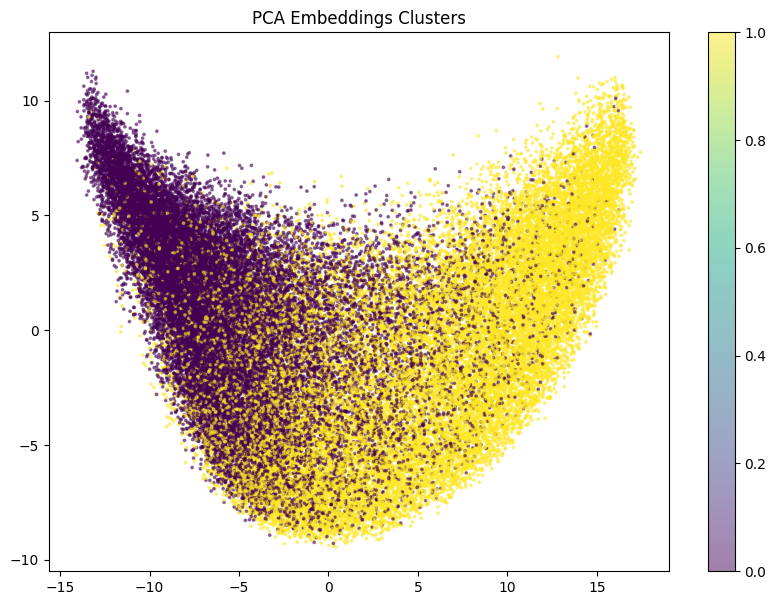

In [14]:
# select number of features
pca_v = PCA(n_components = 2)
embeddings_v = pca_v .fit_transform(embeddings_np)

# Transformed embeddings after reduction
print(embeddings_v.shape)

# visualize the data
pca_xs_v = embeddings_v[:, 0]
pca_ys_v = embeddings_v[:, 1]

visualize_clusters(pca_xs_v, pca_ys_v, labels, "PCA Embeddings Clusters")

In [15]:
# select number of features for clustering models
pca_model = PCA(n_components = 20) # ELBOW 
embeddings_transformed = pca_model.fit_transform(embeddings_np)

# Transformed embeddings after reduction
print(embeddings_transformed.shape)

(49582, 20)


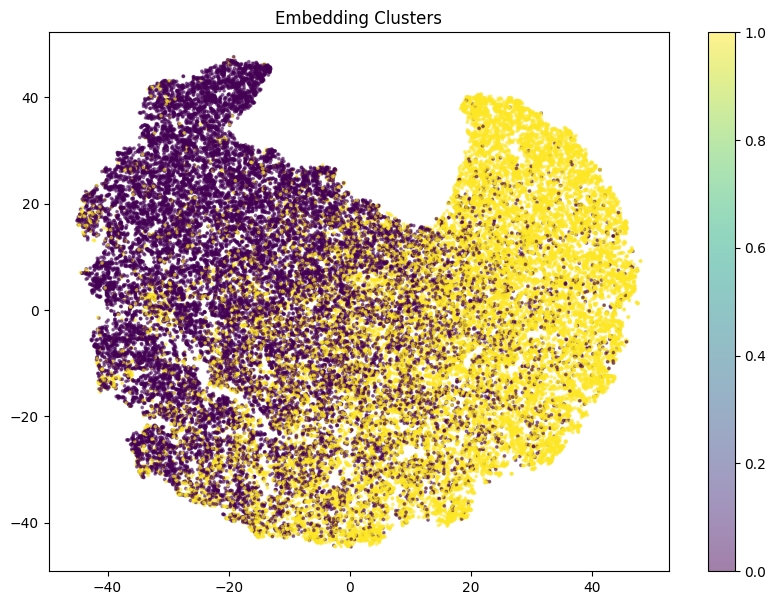

In [29]:
# Visualize reduced 20 feature into 2 features
tsne = TSNE(n_components=2, learning_rate = 150, random_state=42)
tsne_embeddings = tsne.fit_transform(embeddings_transformed)

tsne_xs = tsne_embeddings[:,0]
tsne_ys = tsne_embeddings[:,1]

visualize_clusters(tsne_xs, tsne_ys, labels, "Embedding Clusters")

## HDBSCAN

In [16]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=25, min_samples=60, metric='euclidean')
# hdbscan_labels = clusterer.fit_predict(embeddings_np)
hdbscan_labels = clusterer.fit_predict(embeddings_transformed)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [17]:
df["hdbscan_label"] = hdbscan_labels
df[["cleaned_review", "sentiment", "hdbscan_label"]]

,cleaned_review,sentiment,hdbscan_label
0,reviewer mention watch oz episode ll hook righ...,1,0
1,wonderful little production film technique una...,1,-1
2,think wonderful way spend time hot summer week...,1,1
3,basically s family little boy jake think s zom...,0,-1
4,petter matteis love time money visually stunni...,1,-1
...,...,...,...
49577,think movie right good job not creative origin...,1,1
49578,bad plot bad dialogue bad act idiotic direct a...,0,0
49579,catholic teach parochial elementary school nun...,0,0
49580,m go disagree previous comment maltin second r...,0,-1


In [18]:
ctab = pd.crosstab(df["hdbscan_label"], df["sentiment"])
ctab

sentiment,0,1
hdbscan_label,,
-1,8922,20042
0,15705,3544
1,71,1298


## KMeans Clustering

In [19]:
kmean_model = KMeans(n_clusters = 2)
kmean_model.fit(embeddings_transformed)
kmean_model.inertia_

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2262639.25

In [20]:
k_labels = kmean_model.predict(embeddings_transformed)

df["k_label"] = k_labels
df[["cleaned_review", "sentiment", "k_label"]]

,cleaned_review,sentiment,k_label
0,reviewer mention watch oz episode ll hook righ...,1,0
1,wonderful little production film technique una...,1,1
2,think wonderful way spend time hot summer week...,1,1
3,basically s family little boy jake think s zom...,0,0
4,petter matteis love time money visually stunni...,1,1
...,...,...,...
49577,think movie right good job not creative origin...,1,1
49578,bad plot bad dialogue bad act idiotic direct a...,0,0
49579,catholic teach parochial elementary school nun...,0,0
49580,m go disagree previous comment maltin second r...,0,0


In [21]:
ctab = pd.crosstab(df["k_label"], df["sentiment"])
ctab

sentiment,0,1
k_label,,
0,21921,8869
1,2777,16015


## Agglomerative Hierarichal Clustering

In [22]:
agg_model = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')
agg_labels = agg_model.fit_predict(embeddings_transformed)

df["agg_label"] = agg_labels
df[["cleaned_review", "sentiment", "agg_label"]].sort_values(by = "agg_label")

,cleaned_review,sentiment,agg_label
29845,year old discover house watch constantly seven...,1,0
29834,sensuous nurse italian sexual comedy star time...,1,0
29835,bygone day catholic church sineater individual...,0,0
29836,main criticism movie love story not love story...,1,0
29839,bad level not know start ok good point peeble ...,0,0
...,...,...,...
11296,film trilogy brilliant turkish director nuri b...,1,1
11297,s not wrong crash moon basically episode rocky...,0,1
11300,movie suffer adventure run no enigma solve ill...,0,1
32770,film lot raw potential script sharp dialogue u...,1,1


In [23]:
ctab = pd.crosstab(df["agg_label"], df["sentiment"])
ctab

sentiment,0,1
agg_label,,
0,22417,10977
1,2281,13907


## Model Evaluation

In [28]:
labels = np.array(labels)

mask = hdbscan_labels != -1
filtered_cluster_labels = hdbscan_labels[mask]
filtered_labels = labels[mask]


kmeans_cm = classification_report(labels, k_labels)
hdbscan_cm = classification_report(filtered_labels, filtered_cluster_labels)
agg_cm = classification_report(labels, agg_labels)

print(f"KMeans Confusion Matrix\n {kmeans_cm}")
print("\n")
print(f"HDBSCAN Confusion Matrix\n {hdbscan_cm}")
print("\n")
print(f"Agglomirative Clustering Confusion Matrix\n {agg_cm}")

KMeans Confusion Matrix
               precision    recall  f1-score   support

           0       0.71      0.89      0.79     24698
           1       0.85      0.64      0.73     24884

    accuracy                           0.77     49582
   macro avg       0.78      0.77      0.76     49582
weighted avg       0.78      0.77      0.76     49582



HDBSCAN Confusion Matrix
               precision    recall  f1-score   support

           0       0.82      1.00      0.90     15776
           1       0.95      0.27      0.42      4842

    accuracy                           0.82     20618
   macro avg       0.88      0.63      0.66     20618
weighted avg       0.85      0.82      0.78     20618



Agglomirative Clustering Confusion Matrix
               precision    recall  f1-score   support

           0       0.67      0.91      0.77     24698
           1       0.86      0.56      0.68     24884

    accuracy                           0.73     49582
   macro avg       0.77      0

## t-SNE Visualization

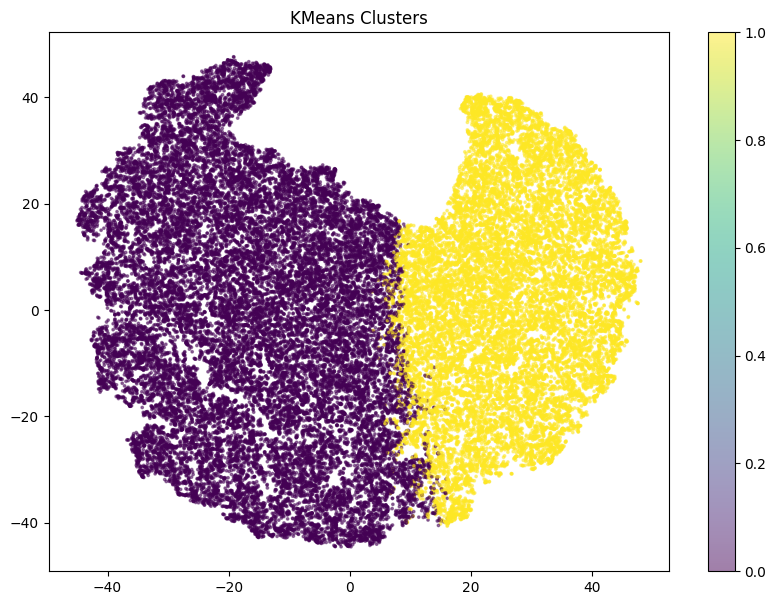

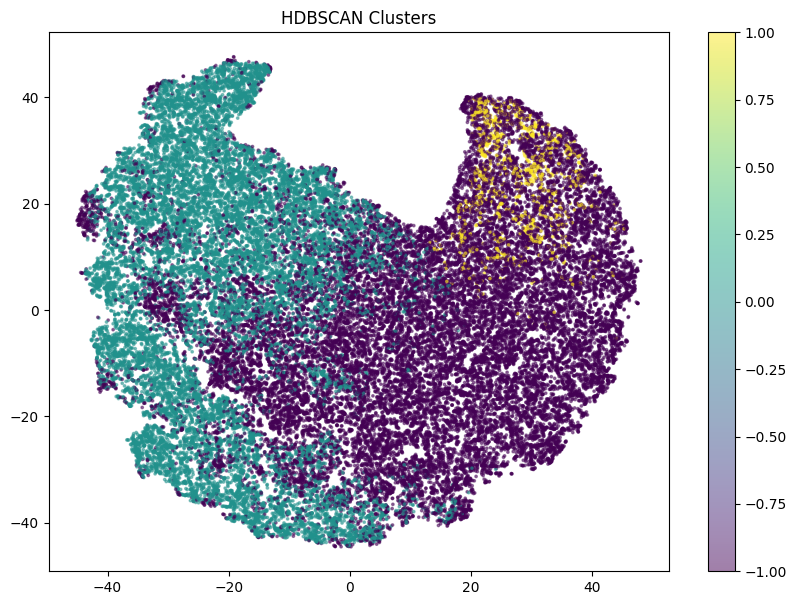

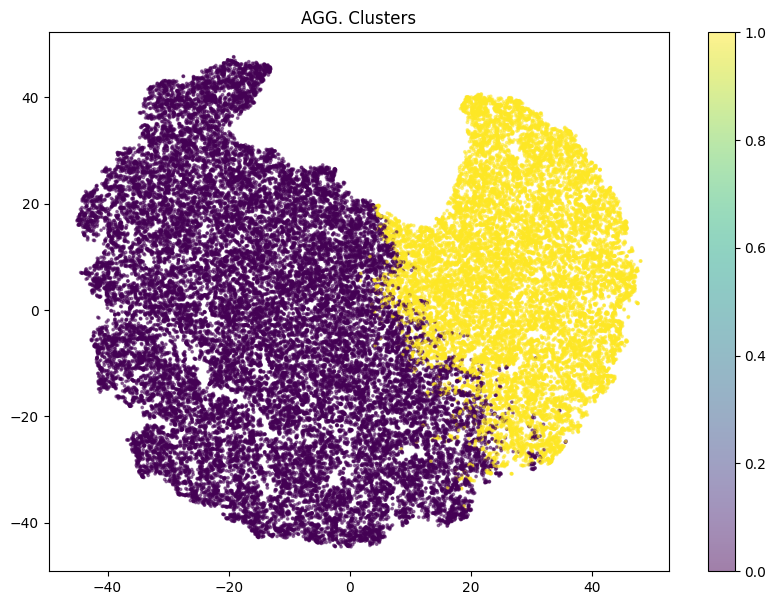

In [33]:
# Plot KMeans clusters
visualize_clusters(tsne_xs, tsne_ys, k_labels, "KMeans Clusters")

# Plot HDBSCAN
visualize_clusters(tsne_xs, tsne_ys, hdbscan_labels, "HDBSCAN Clusters")

# Plot Agglomirative clustering
visualize_clusters(tsne_xs, tsne_ys, agg_labels, "AGG. Clusters")